                                    Music Recommendation System

### Dataset: 

Datasets: 
    
 Implicit rating of 1million User(number of time a song played): http://millionsongdataset.com/tasteprofile/

#### Packages: 

In [1]:
import numpy as np
import os
import fnmatch
import sys

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import Bucketizer
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, RobustScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, col, isnan, when, count, sum, mean, rand
from pyspark_dist_explore import hist

from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import row_number, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, avg, approx_count_distinct, floor, dense_rank

import findspark
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType

from pyspark.sql.functions import  expr


#### Create spark cluster: 

In [2]:
findspark.init()

In [3]:
# Create a SparkSession with the specified application name
# Configure the executor memory to allocate 10 gigabytes of memory to each executor
# Configure the driver memory to allocate 6 gigabytes of memory to the driver program
# Get or create the SparkSession

spark = SparkSession.builder \
    .appName("train_triplets") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()



In [4]:
data_path = 'train_triplets.txt'

In [5]:
# define schema, nullable is set true
schema = StructType([
    StructField('userId', StringType(), True),
    StructField('songId', StringType(), True),
    StructField('play_count', IntegerType(), True)])

####  Reading Datasets: 

In [6]:
# Read the csv file, each coloumn is divided by a tab (from csv into a spark dataframe)
data_user_song_rating_full = spark.read.option("delimiter", "\t").schema(schema).csv(data_path)

In [7]:
data_user_song_rating_full.columns

['userId', 'songId', 'play_count']

In [8]:
data_user_song_rating_full.persist()

DataFrame[userId: string, songId: string, play_count: int]

In [36]:
data_user_song_rating_full.describe().show()

+-------+--------------------+------------------+-----------------+
|summary|              userId|            songId|       play_count|
+-------+--------------------+------------------+-----------------+
|  count|            48373586|          48373586|         48373586|
|   mean|                null|              null|2.866858847305635|
| stddev|                null|              null|6.437724686877057|
|    min|00000b72200188206...|SOAAADD12AB018A9DD|                1|
|    max|fffff9534445f481b...|SOZZZWN12AF72A1E29|             9667|
+-------+--------------------+------------------+-----------------+



check 
- missing values in each column
- duplicate in combination of userId and SongId
 


Check, missing values in each column:

In [ ]:
#from pyspark.sql.functions import col, count, isnan, when
def column_with_missing_value(df):
    # Create a list of expressions to check for null, NaN, empty strings, 'None', and 'NULL' values
    null_exprs = [count(when(col(c).isNull() | isnan(c) | (col(c) == '') | 
                         col(c).isin(['None', 'NULL']), c)).alias(c) for c in df.columns]

    # Apply the expressions to the DataFrame
    ps_df = df.select(null_exprs)

    # Create a list of columns with missing values
    cols_with_missing_values = [c for c in ps_df.columns if ps_df.select(c).first()[0] > 0]

    # Select only those columns with missing values
    ps_df.select(cols_with_missing_values).show()

In [22]:
# missing values
column_with_missing_value(data_user_song_rating_full)

++
||
++
||
++



There is no missing values in the columns.

Check, Duplicate in combination of userId and SongId:

In [38]:
# group the data by userId and songId, and count the number of times each song was played by a user
# count the number of rows where count is greater than 1 : should be zero
#data_imp_rating_full.groupBy(['userId', 'songId']).count().filter('count > 1').count()

In [ ]:
#There is no duplication in case of ['userId', 'songId'].

###### Check point dataset and persist

In [9]:
data_filtered = data_user_song_rating_full

In [10]:
data_filtered.persist()

DataFrame[userId: string, songId: string, play_count: int]

### In order to split data to train and test we need to clean and filter our data:

#### Part 1: Cleaning and Filtering
- The dataset should contain information about the user, song, and play count:
- Play count:
  - The play count is represent the number of times a user has played a particular song.
  - No play count should be equal to 1.
  - Play count should be checked for anomalies and outliers
  
- Song Id:
  - No SongId should appear in the dataset only once.
  
- user Id: 
  - Each user should have at least 6 songs.
  

#### Part 2: Split Data Set to Train and Test Set
- Each user should have listened to at least 6 songs.( already done in part 1)
- The dataset should be split into training and test sets, with 80% of each user's songs in the training set and 20% in the test set. all users should be in bot train and test data sets.
- Each user 

#### Part 3: Store Train and Test data Sets as Csv file

##  Part 1

##         Play Count Column

- define some functions:

In [15]:
#
def plot_play_count(data_filtered, lower_range, sample_fraction=0.1):
    # Sample a subset of data for boxplot
    data_boxplot = data_filtered.select('play_count').sample(False, sample_fraction).collect()
    data_boxplot = [row['play_count'] for row in data_boxplot]

    # Sample a subset of data for histogram
    data_histogram = data_filtered.filter(f'play_count > {lower_range}').select('play_count').sample(False, sample_fraction).collect()
    data_histogram = [row['play_count'] for row in data_histogram]

    # Create a figure with two subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot the boxplot in the first subplot
    sns.boxplot(x=np.array(data_boxplot), ax=axs[0])
    axs[0].set_title('play_count')

    # Plot the histogram in the second subplot
    axs[1].hist(data_histogram, bins=100)
    axs[1].set_xlabel('Play Count')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Play Count')

    # Display the plot
    plt.show()



In [16]:
#
def plot_play_count_histogram(data_filtered, bucket_splits):
    # Define the bucketizer
    bucketizer = bucketizer = Bucketizer(splits=bucket_splits, inputCol="play_count", outputCol="bucket")
    
    # Transform the data to bucketized form
    data_filtered_buck = bucketizer.transform(data_filtered)
    
    # Group by bucket and count the occurrences
    counts = data_filtered_buck.groupBy('bucket').count().orderBy('bucket').collect()
    
    # Create a list of labels for the x-axis ticks
    labels = ['{}-{}'.format(int(bucket_splits[i]), int(bucket_splits[i+1])) if i < len(bucket_splits)-1 else '{}+'.format(int(bucket_splits[i])) for i in range(len(bucket_splits)-1)]
    
    # Plot the histogram with labeled buckets
    plt.bar(range(len(counts)), [row['count'] for row in counts])
    plt.xlabel('Play count buckets')
    plt.ylabel('Frequency')
    plt.xticks(range(len(counts)), labels, rotation=45, ha='right')
    plt.show()
    


In [17]:
def IQR(df, column, n):
    # Calculate the quartiles, median, and IQR
    data_filtered = df
    quantiles = data_filtered.approxQuantile(column, [0.25, 0.5, 0.75], 0.05)
    q1 = quantiles[0]
    median = quantiles[1]
    q3 = quantiles[2]
    iqr = q3 - q1

    # Calculate the upper and lower bounds for outliers
    lower_bound = q1 - n * iqr
    upper_bound = q3 + n * iqr

    # Filter out the outliers
    outliers = data_filtered.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    
    # Return the result
    return q1, median, q3, iqr, lower_bound, upper_bound



def print_IQR_related_values(df, column, n):
    
    q1, median, q3, iqr, lower_bound, upper_bound = IQR(df, column, n)
    
    print("\nThe following values represent the Interquartile Range (IQR),")
    print("based on the number of standard deviations {n} used for determining the bounds:", {n})
    print("\n")
    print('Q1:', q1)
    print('Median:', median)
    print('Q3:', q3)
    print('IQR:', iqr)
    print('Lower bound:', lower_bound)
    print('Upper bound:', upper_bound)

#### Eliminate the Outliers based on upper_bound

In [18]:
def filter_by_iqr(df, column, k):
    # Calculate the IQR
    q1, median, q3, iqr, lower_bound, upper_bound= IQR(df,"play_count",k)

    # Filter the DataFrame
    filtered_df = df.filter(col(column) <= upper_bound)
    print('Filter the DataFrame based on IQR :')
    print('upper_bound number of standard deviations used for determining the bounds = ',k)
    
    return filtered_df

##### No play count should be equal to 1.

In [19]:
# No play count should be equal to 1.
data_filtered = data_filtered.filter('play_count > 1')

In [20]:
#show the count of data
data_filtered.count()

19617620

In [21]:
#Persisting a dataset means caching it in memory or on disk
data_filtered.persist()

DataFrame[userId: string, songId: string, play_count: int]

##### Finding  outliers and anomalies 

In [31]:
print_IQR_related_values(data_filtered,"play_count",1.5)


The following values represent the Interquartile Range (IQR),
based on the number of standard deviations {n} used for determining the bounds: {1.5}


Q1: 2.0
Median: 4.0
Q3: 6.0
IQR: 4.0
Lower bound: -4.0
Upper bound: 12.0


In [32]:
print_IQR_related_values(data_filtered,"play_count",3)


The following values represent the Interquartile Range (IQR),
based on the number of standard deviations {n} used for determining the bounds: {3}


Q1: 2.0
Median: 4.0
Q3: 6.0
IQR: 4.0
Lower bound: -10.0
Upper bound: 18.0


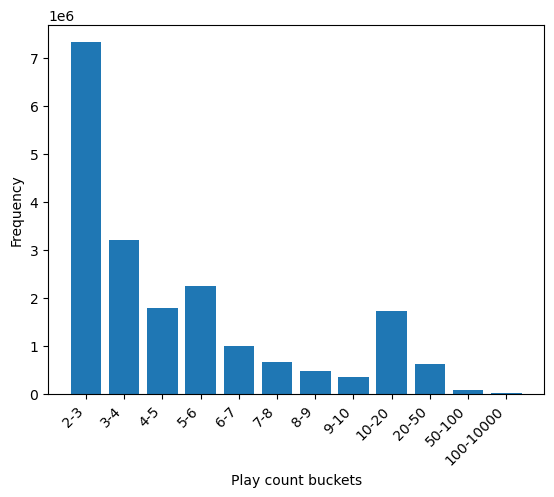

In [22]:
# Define the bucket boundaries
bucket_splits = [  2, 3, 4, 5,6,7,8,9,10, 20, 50, 100, 10000]

#show the histogram baset on bucket range
plot_play_count_histogram(data_filtered, bucket_splits)

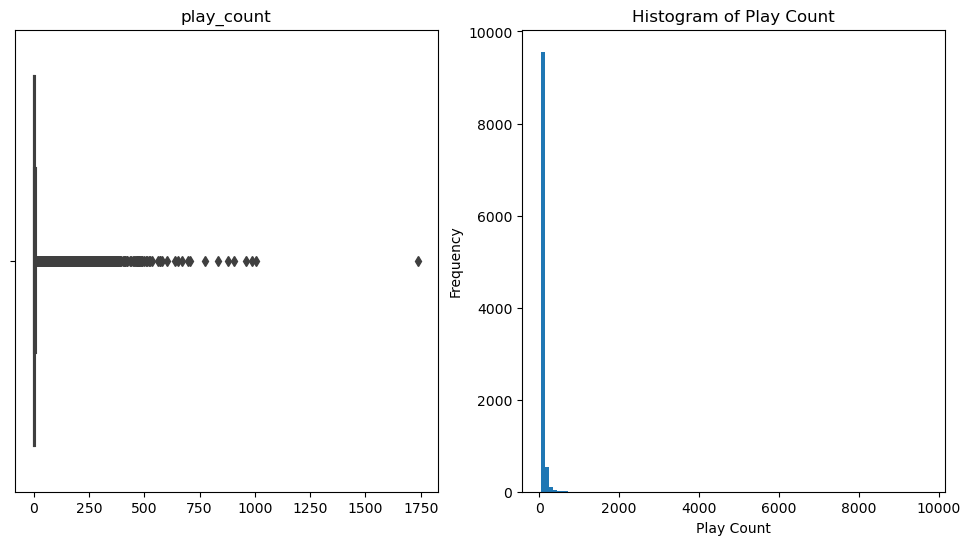

In [24]:
plot_play_count(data_filtered, 50, sample_fraction=0.1)

In [42]:
# Check if eliminate data by playcount <=18 , how much data will be missed
current_size, size18andLess = data_filtered.count(),data_filtered.filter(col("play_count") <= 50).count()
print(current_size,' - ', size18andLess,' = ',current_size - size18andLess)

19617620  -  19515766  =  101854


## Filter the DataFrame based on IQR upper_bound

In [25]:
# Filter the DataFrame based on IQR upper_bound
data_filtered = filter_by_iqr(data_filtered, "play_count", 3)


Filter the DataFrame based on IQR :
upper_bound number of standard deviations used for determining the bounds =  3


In [51]:
#Show data count
data_filtered.count()

18814254

In [26]:
#Create a checkpoint
data_filtered_play_count = data_filtered

#persist dataset
data_filtered.persist()

DataFrame[userId: string, songId: string, play_count: int]

##### No SongId should appear in the dataset only once & Each user should have listened to at least 6 songs.

###### Functions:

In [32]:
def calculate_min_row_By_column(df, column):
    min_row_count = df.groupBy(column).count().agg({"count": "min"}).first()[0]
    print(f"Minimum row count for each {column}: {min_row_count}")
    return min_row_count

In [34]:
def filter_users_by_solo_songs(df):
    # No SongId should appear in the dataset only once.
    # Group the data by songId and count the number of plays
    song_counts = df.groupBy("songId").agg(count("*").alias("count"))

    # Filter out songs with a count less than or equal to 1
    song_counts_filtered = song_counts.filter("count > 1")

    # Join the filtered song counts with the original data on songId, keeping only inner matches, and drop the count column
    filtered_df = df.join(song_counts_filtered, "songId", "inner").drop("count")
    
    print ('Filter out songs with a count less than or equal to 1') # \nNew dataframe coount is:',filtered_df.count())
    return filtered_df


In [35]:
# filter out users with less than min_song_count: n unique SongIds in order of splitting the data to train and test. 
#filtering out users with less than n unique SongIds have a minimum level of diversity in the listening history of users.
#This can help to split the data into train and test sets more effectively and and be able to evaluate the sys

def filter_user_by_song_count(df, min_song_count):
    # Group the data by userId and count the number of unique songs each user has listened to
    user_song_counts = df.groupBy("userId").agg(count("songId").alias("song_count"))

    # Filter out users with less than the specified minimum song count
    user_song_counts_filtered = user_song_counts.filter(f"song_count >= {min_song_count}")

    # Join the filtered user song counts with the filtered data on userId, keeping only inner matches, and drop the song_count column
    filtered_data = df.join(user_song_counts_filtered, "userId", "inner").drop("song_count")
    
    filtered_data_count = filtered_data.count()
    print(f"Filtered out users with song count less than or equal to {min_song_count}")
    #print(f"New DataFrame count: {filtered_data_count}")

    return filtered_data


In [62]:
# Minimum row count for each songId
calculate_min_row_By_column(data_filtered, 'songId')

Minimum row count for each songId: 1


In [63]:
#number of users have played only one song
calculate_min_row_By_column(data_filtered, 'userId')

Minimum row count for each userId: 1


### 6 songs

In [64]:
data_filtered = filter_user_by_song_count(data_filtered, 6)

data_filtered.persist()

Filtered out users with song count less than or equal to 6


In [36]:
#initial some variables

min_song_group, min_user_playlist, condition, num =1, 1, True, 1

while condition:
    print('\ncycle', num)
    
    # Check the first condition: min_song_group == 1
    if min_song_group == 1:

        data_filtered = filter_users_by_solo_songs(data_filtered)

        data_filtered.persist()

        min_user_playlist = calculate_min_row_By_column(data_filtered, 'userId')
        
        data_filtered.persist()
        
        condition = min_user_playlist < 6
        
    if min_user_playlist < 6:

        data_filtered = filter_user_by_song_count(data_filtered, 6)

        data_filtered.persist()

        # Minimum row count for each songId
        min_song_group = calculate_min_row_By_column(data_filtered, 'songId')
        
        data_filtered.persist()
        
        condition = min_song_group == 1
    
    num+=1


cycle 1
Filter out songs with a count less than or equal to 1
Minimum row count for each userId: 1
Filtered out users with song count less than or equal to 6
Minimum row count for each songId: 1

cycle 2
Filter out songs with a count less than or equal to 1
Minimum row count for each userId: 5
Filtered out users with song count less than or equal to 6
Minimum row count for each songId: 1

cycle 3
Filter out songs with a count less than or equal to 1
Minimum row count for each userId: 5
Filtered out users with song count less than or equal to 6
Minimum row count for each songId: 2


### review data

In [38]:
data_filtered.describe().show()

+-------+--------------------+------------------+------------------+
|summary|              userId|            songId|        play_count|
+-------+--------------------+------------------+------------------+
|  count|            18017624|          18017624|          18017624|
|   mean|                null|              null| 4.389397736349698|
| stddev|                null|              null|3.2446516858100547|
|    min|00001638d61892368...|SOAAADD12AB018A9DD|                 2|
|    max|fffff9534445f481b...|SOZZZWN12AF72A1E29|                18|
+-------+--------------------+------------------+------------------+



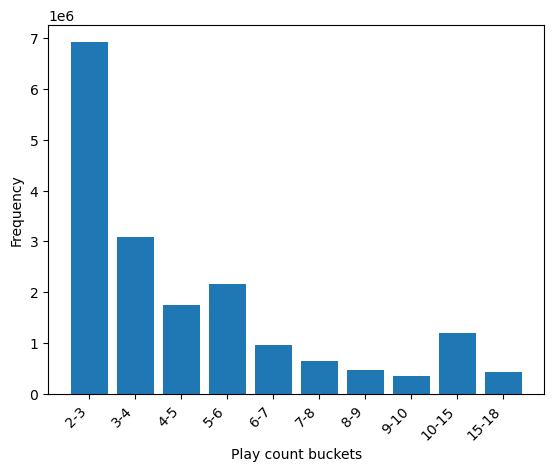

In [39]:
bucket_splits = [  2, 3, 4, 5,6,7,8,9,10, 15, 18]
plot_play_count_histogram(data_filtered, bucket_splits)

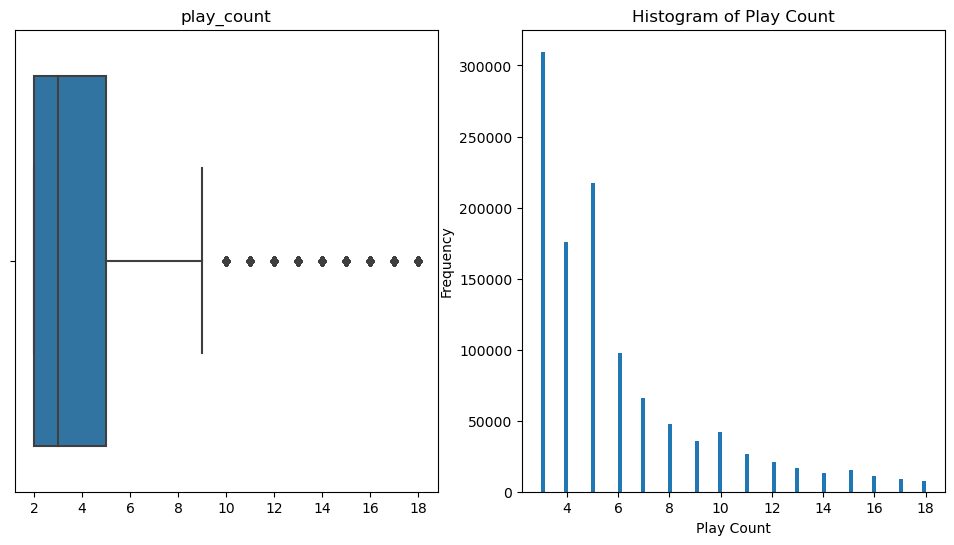

In [40]:
plot_play_count(data_filtered, 2, sample_fraction=0.1)

In [37]:
# Specify the output path for the CSV files
output_path = 'filtered_data.csv'

# Coalesce the DataFrame to a single partition to minimize the number of output files
coalesced_df = data_filtered.coalesce(1)

# Write the coalesced DataFrame to a CSV file
coalesced_df.write.csv(output_path, header=True, mode='overwrite')


### Creat check point and persist

In [41]:
cleaned_data = data_filtered

cleaned_data.persist()

DataFrame[userId: string, songId: string, play_count: int]

## Part 2

### Creating user Index and song Index on cleaned data: 

In [42]:
#### Creating user Index and song Index : 

#from pyspark.sql import Window
#from pyspark.sql.functions import dense_rank

# Define a window specification
window_spec = Window.orderBy("userId")

# Add a userIdIndex column with unique index values
cleaned_data = cleaned_data.withColumn("userIdIndex", dense_rank().over(window_spec))

# Define a window specification
window_spec = Window.orderBy("songId")

# Add a songIdIndex column with unique index values
data_with_indices = cleaned_data.withColumn("songIdIndex", dense_rank().over(window_spec))


In [43]:
# Show the updated DataFrame
data_with_indices.head(5)

[Row(userId='8cf21d682f872dbe91296690359af2010e5195ca', songId='SOAAADD12AB018A9DD', play_count=3, userIdIndex=409178, songIdIndex=1),
 Row(userId='6e4d60a9f2d014958a3de6cf8007ca49050581cb', songId='SOAAADD12AB018A9DD', play_count=8, userIdIndex=320261, songIdIndex=1),
 Row(userId='736f40dcc9e45e2f03ffc0edb90ebb1954d8f9d6', songId='SOAAADE12A6D4F80CC', play_count=2, userIdIndex=335188, songIdIndex=2),
 Row(userId='f4058a3849ba9ef1a23884a5274ec92cb9d52649', songId='SOAAADE12A6D4F80CC', play_count=3, userIdIndex=709139, songIdIndex=2),
 Row(userId='5c526a981bc28ef4eb44d7bece91015b5cca085b', songId='SOAAADZ12A8C1334FB', play_count=2, userIdIndex=267969, songIdIndex=3)]

In [44]:
# Show the updated DataFrame column
data_with_indices.columns

['userId', 'songId', 'play_count', 'userIdIndex', 'songIdIndex']

#### persisting persist:


In [45]:
data_with_indices.persist()

DataFrame[userId: string, songId: string, play_count: int, userIdIndex: int, songIdIndex: int]

# Train and Test

In [46]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

# Calculate the count of songs for each user
user_counts = data_with_indices.groupBy("userIdIndex").count()

# Create a window specification to partition by userId and order randomly
window_spec = Window.partitionBy("userIdIndex").orderBy(rand())

# Assign row numbers to each song for every user
user_counts_with_random = data_with_indices.withColumn("row_number", row_number().over(window_spec))

# Join the row numbers back to the user_counts DataFrame
user_counts_with_random = user_counts.join(user_counts_with_random, on=["userIdIndex"], how="inner")

# Select songs with row_number <= count * 0.8 for the train set
train_data = user_counts_with_random.filter("row_number <= count * 0.8")

# Drop unnecessary columns from the train set
train_data = train_data.drop("count", "row_number")

# Select the test set
test_data = user_counts_with_random.join(train_data, on=["userIdIndex", "songIdIndex"], how="left_anti")

# Drop unnecessary columns from the train set
test_data = test_data.drop("count", "row_number")


In [47]:
# show train and test colummns name
train_data.columns,test_data.columns

(['userIdIndex', 'userId', 'songId', 'play_count', 'songIdIndex'],
 ['userIdIndex', 'songIdIndex', 'userId', 'songId', 'play_count'])

In [48]:
# Calculate count of train and test datasets
print('Train set count: ',train_data.count())
print('Test set count: ', test_data.count())

# Calculate distinct userId values in train and test datasets
print('Train distinct users\' count: ', train_data.select("userIdIndex").distinct().count())
print('Test distinct users\' count: ',test_data.select("userIdIndex").distinct().count())


Train set count:  14095482
Test set count:  3922142
Train distinct users' count:  744025
Test distinct users' count:  744025


# Store train and test data set as csv file

In [60]:
# Specify the output path for the CSV files
output_path = 'train_data.csv'

# Coalesce the DataFrame to a single partition to minimize the number of output files
coalesced_df = train_data.coalesce(1)

# Write the coalesced DataFrame to a CSV file
coalesced_df.write.csv(output_path, header=True, mode='overwrite')


In [59]:
# Specify the output path for the CSV files
output_path = 'test_data.csv'

# Coalesce the DataFrame to a single partition to minimize the number of output files
coalesced_df = test_data.coalesce(1)

# Write the coalesced DataFrame to a CSV file
coalesced_df.write.csv(output_path, header=True, mode='overwrite')
